In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [292]:
import pandas as pd

class ProcessAmazon():
    """Read, filter, aggregate by ProductId, and generate X matrix"""

    def __init__(self, raw_data_filename, num_reviews_filter):
        """Initialize attributes."""
        self.raw_data_filename = raw_data_filename
        self.num_reviews_filter = num_reviews_filter
        self.raw_data = self.read_and_report()
        self.grouped_by_userid = self.group_by_userid()
        self.filtered = self.filter_()
        self.grouped_by_productid = self.group_by_productid()
        self.X = self.write_X()
    
    def read_and_report(self):
        """Read Amazon csv, report on file structure"""
        data = pd.read_csv(self.raw_data_filename)
        print(self.raw_data_filename, "has", data.shape[0], "rows and", data.shape[1], "columns. First five observations:")
        print(data.head(5))
        print(50 * '-')
        return data
    
    def group_by_userid(self):
        """Group by UserId and look at the distribution of number of reviews"""
        grouped_by_uid = self.raw_data.groupby('UserId').count()
        print('Distribution of number of reviews for each UserId:')
        print(grouped_by_uid['ProductId'].value_counts())
        print(50 * '-')
        return grouped_by_uid
    
    def filter_(self):
        """Filter out reviewers with fewer than x reviews"""
        filtered = self.grouped_by_userid[self.grouped_by_userid['Id'] > self.num_reviews_filter]
        print('filtereeed----')
        
        # remove redundant columns
        filtered_final = filtered.drop(filtered.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], axis=1)
        # recreate UserId from index
        filtered_final['UserId'] = filtered_final.index
        # rename columns
        filtered_final.columns = ['num_reviews', 'UserId']
        filtered_final.reset_index(drop=True, inplace=True)
        # left merge filtered list with raw data
        filtered = pd.merge(filtered_final, self.raw_data, how='left', on='UserId')
        print("Filtered data has", filtered.shape[0], "rows and", filtered.shape[1], "columns. First five observations:")
        print(filtered.head(5))
        print(50 * '-')
        return filtered
    
    def group_by_productid(self):
        """Group by ProductId and create a column that lists each UserId (separated by spaces) who reviewed that product"""
        grouped_by_pid = self.filtered.groupby('ProductId')
        grouped_by_pid2 = grouped_by_pid['UserId'].apply(lambda x: ' '.join(x)).reset_index()
        grouped_by_pid3 = grouped_by_pid['Text'].apply(lambda x: ' '.join(x)).reset_index()
        
        group = pd.merge(grouped_by_pid2, grouped_by_pid3)
        print(50 * '-')
        return group
    
    def write_X(self):
        """use bag of words to create boolean X to represent reviews by UserId (one UserId per column)"""
        from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer
        count = CountVectorizer()
        # hv = HashingVectorizer(n_features=2 ** 14, alternate_sign=False, stop_words='english', lowercase=False)
        # transformer = TfidfTransformer()
        
        self.grouped_by_productid['combined'] = self.grouped_by_productid['UserId'] + self.grouped_by_productid['Text']
        uidArray = self.grouped_by_productid['combined']
        
        userFeatures = count.fit_transform(uidArray)
        # userFeatures_transformed = transformer.fit_transform(userFeatures)
        print("Shape of final X matrix:", userFeatures.shape)
        return userFeatures

In [397]:
import pandas as pd
class ViewClusteringResults():
    """Merge cluster definitions to raw data and view samples of clustering results, showing review summaries and texts."""
    
    def __init__(self, data_instance, model_instance):
        """Initialize attributes"""
        self.data_instance = data_instance
        self.model_instance = model_instance
    
    def merge_labels(self):
        """Merge cluster labels to raw data (as structured in Amazon.csv)"""
        labels_tomerge = pd.DataFrame(self.model_instance.labels_)
        labelled_products = pd.concat([self.data_instance.grouped_by_productid[['ProductId', 'UserId', 'Text']], labels_tomerge], axis=1, ignore_index=True)
        labelled_products.columns = ['ProductId', 'UserIds', 'Text', 'cluster']
        # merged = pd.merge(labelled_products, self.data_instance.raw_data, how='left', on='ProductId')
        # merged_lite = merged[['ProductId', 'cluster', 'Summary', 'Text']]
        return labelled_products

    def view_cluster_samples(self, n_samples):
        """Print x samples of cluster results for each cluster, showing details of product reviews."""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            print(50 * '-')
            print('cluster: ', i)
            cluster = merged.loc[merged['cluster'] == i]
            print('cluster size: ', cluster.shape)
            print(cluster.sample(n_samples))

In [294]:
# process Amazon.csv, filtering out people who left 4 or fewer reviews
amazonData = ProcessAmazon('/Users/artemshuliak/Desktop/parsons/Semester 6/ML /ml-master/final_assignment_3/DATA/Amazon.csv', 4)

/Users/artemshuliak/Desktop/parsons/Semester 6/ML /ml-master/final_assignment_3/option_1/Amazon.csv has 455000 rows and 13 columns. First five observations:
   Unnamed: 0      Id   ProductId          UserId       ProfileName  \
0      138806  138807  B000E63LME  A1CQGW1AOD0LF2  Alena K. "Alena"   
1      469680  469681  B004ZIH4KM  A37S7U1OX2MCWI        Becky Cole   
2      238202  238203  B003ZXE9QA  A2OM6G73E64EQ9              jeff   
3      485307  485308  B001RVFERK  A25W349EE97NBK          Tangent4   
4      375283  375284  B000OQZNTS  A3CPPW0HUC07YS       Amy Nicolai   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       2      2  1294185600   
1                     0                       0      5  1349740800   
2                     0                       0      5  1329264000   
3                     1                       1      4  1248307200   
4                     0                       0      5  1333238400

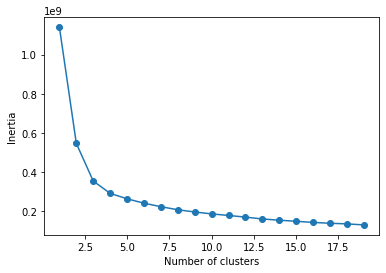

In [337]:
# first attempt at fitting K means to view change in Inertia
from sklearn.cluster import KMeans

# container to store inertia scores over iterations
distortions = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in range(1, 20):
    km = KMeans(n_clusters=i)
    km.fit(amazonData.X)
    distortions.append(km.inertia_)
    
# vizualize change in inertia
plt.plot(range(1, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [338]:
# fit KMeans with 10 clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10)
km.fit(amazonData.X)

KMeans(n_clusters=10)

In [398]:
# create an instance of ViewClusteringResults to view results of final KMeans fit
viz = ViewClusteringResults(amazonData, km)

In [400]:
# view samples of product reviews, organized by KMeans cluster results
viz.view_cluster_samples(10)

--------------------------------------------------
cluster:  1
cluster size:  (53, 4)
        ProductId                                            UserIds  \
24964  B004FGWU9O  A10H24TDLK2VDP A10H24TDLK2VDP A10SVA00I7XVZF A...   
22638  B003VXL0V6  A10H24TDLK2VDP A10H24TDLK2VDP A10SVA00I7XVZF A...   
30508  B008RWUHA6  A10E3F50DIUJEE A110RS7QL8Q1UX A11SWG9T60IQH8 A...   
27390  B005A1LINC  A10Z8FC0SMU5VQ A11IKWE7B29TOJ A13KW5I9IHQ039 A...   
22634  B003VXHGE6  A10H24TDLK2VDP A10H24TDLK2VDP A10H24TDLK2VDP A...   
15517  B001LG945O  A12S8UQEIPZJKE A13WEKTB63G78Y A1484U2Y4YFX2R A...   
27875  B005GYULZY  A10R9LB4QJNG5X A12O5SEIF162P8 A12PN254PTSGU5 A...   
25402  B004JRMG98  A12DQZKRKTNF5E A13WOT3RSXKRD5 A14LG64GIVZIGS A...   
15522  B001LGGH54  A108XP24UESKSV A11EIDY6DD40CS A12E0Y0J6584RT A...   
23327  B0041CIR62  A10YWQ4AAAE29O A11EXFO14WEJM1 A12ENBT314RFXR A...   

                                                    Text  cluster  
24964  First, let me say that I prefer extra-bold K-C

ValueError: Cannot take a larger sample than population when 'replace=False'